In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sb
from sklearn.decomposition import NMF

# Loading the data

data = pd.read_csv("data/forNMF_350_850_normalized_by_apogee.csv")
data.drop(columns=data.columns[0], axis=1,  inplace=True)
data = data[data['Meter'] > 1]
curve_columns = data.columns[0:150]
data['meanCurveValue'] = data[curve_columns].mean(axis=1)
data = data[data['meanCurveValue'] < 30] # TODO
print(data)


             353        356        359        363        366        369  \
79      2.881260   2.911879   3.519868   3.544630   3.416003   3.396207   
80      3.027650   2.994665   3.627177   3.672717   3.515654   3.501742   
81      3.212806   3.201684   3.912144   3.961563   3.743247   3.791581   
82      2.807189   2.872891   3.536646   3.515218   3.442610   3.447435   
83      3.028180   3.014566   3.670088   3.769465   3.575679   3.547810   
...          ...        ...        ...        ...        ...        ...   
11460  30.421288  29.386884  32.790397  31.948612  29.794621  29.271311   
11461  31.130467  30.022422  33.419581  32.488324  30.277005  29.774766   
11462  37.025514  35.751751  40.102273  39.075976  36.376634  35.798666   
11465  51.335152  49.136354  55.189733  53.547468  50.258905  49.714594   
11468  48.217757  46.090309  51.471092  50.517245  46.790751  46.416417   

             373        376        379        383  ...       843       846  \
79      3.643360   3.

/tmp/ipykernel_8641/1017354415.py:13: DtypeWarning: Columns (155) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/forNMF_350_850_normalized_by_apogee.csv")


/tmp/ipykernel_8641/184622707.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  p = sb.scatterplot(tmp, y='value', x='variable',


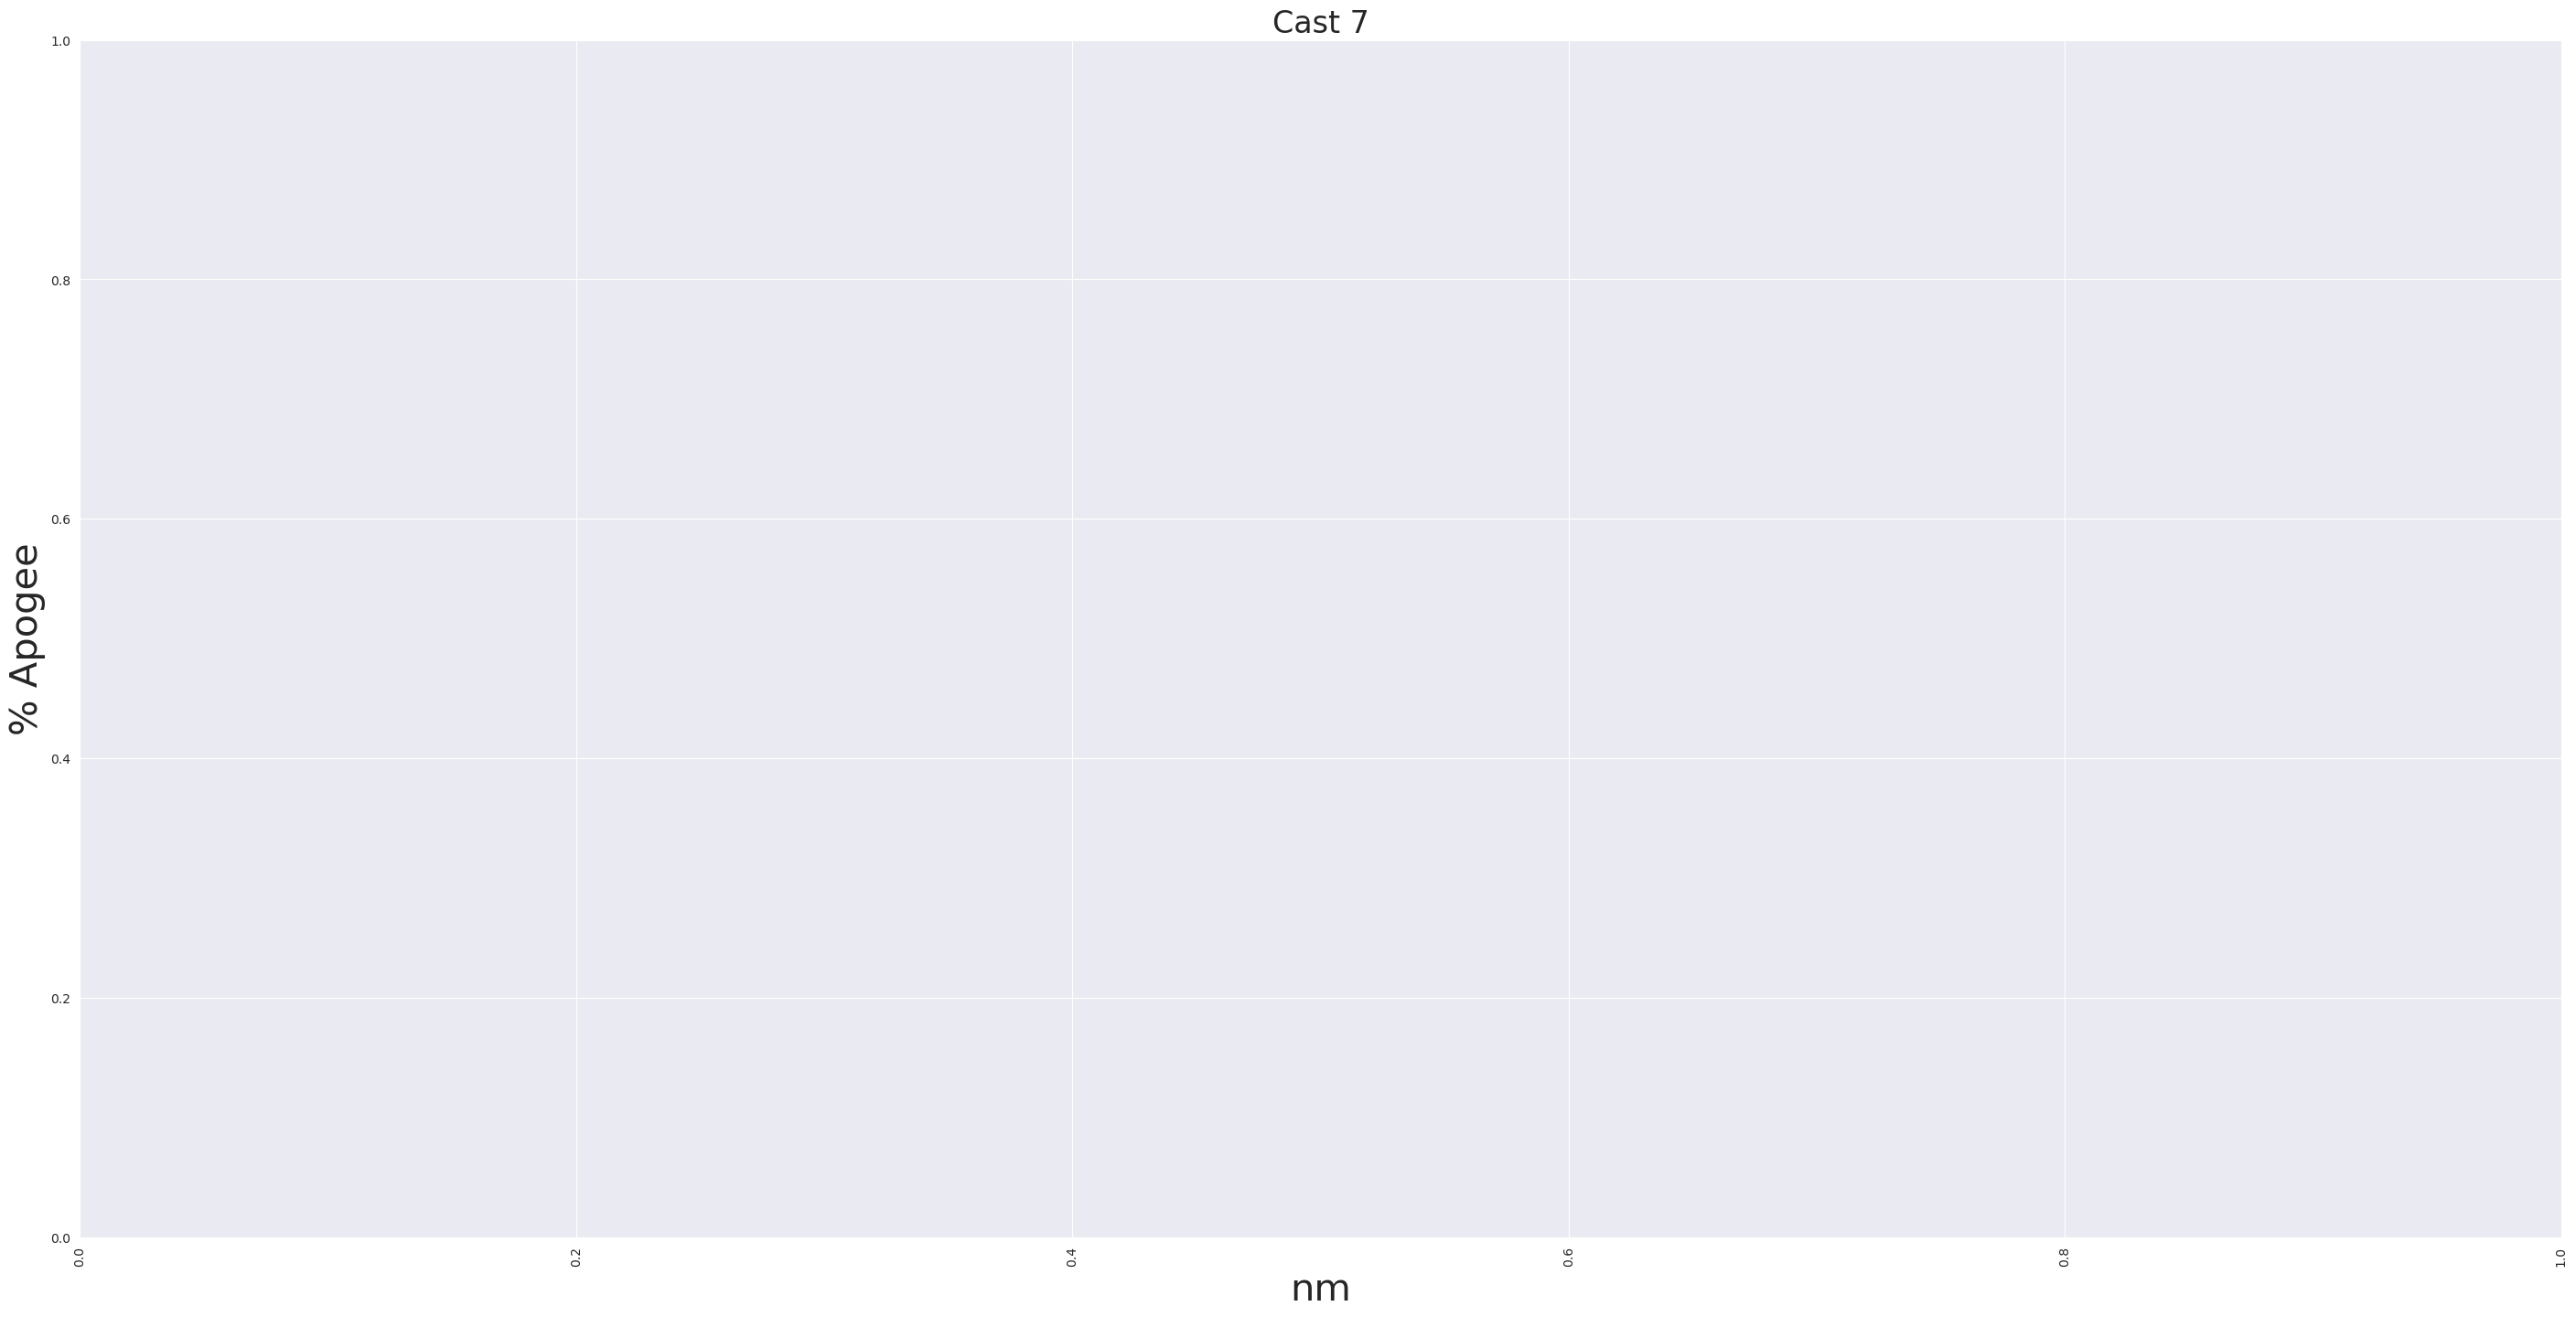

In [2]:
# Visualize curves by depth

tmp = data[data['Cast'] == 'Jezero5']
tmp = tmp[tmp['Sensor'] == 'DW']
tmp = tmp.melt(id_vars=['Meter'], value_vars=curve_columns)

plt.figure(figsize=(35,17))
p = sb.scatterplot(tmp, y='value', x='variable',
               hue='Meter',
               hue_norm=(0,50),
               palette=sb.color_palette("coolwarm", as_cmap=True))
sb.set(font_scale=2)
p.set_xlabel("nm",fontsize=30)
p.set_ylabel("% Apogee",fontsize=30)
plt.xticks(rotation=90)
plt.title("Cast 7")
plt.show()


In [24]:
import warnings
warnings.filterwarnings("ignore")
import random
from tqdm import tqdm
# Find optimal K, solver, distance measure, etc

var = np.array(data[curve_columns]).var()
print(var)
res = []
for seed in tqdm(random.sample(range(1, 10000), 50)):
    for c in [2,3,4,5,6,7,8,9,10]:
        for init in ['nndsvda']:
            for s in ['mu']:
                for l in ['frobenius', 'kullback-leibler']:
                    if s == 'cd' and l == 'kullback-leibler':
                        print("cd and kullback solver cannot go together")
                    else:
                        model = NMF(n_components=c, init=init,
                                    random_state=seed, solver=s,
                                    beta_loss=l, max_iter=1000, verbose=0)
                        W = model.fit_transform(data[curve_columns])
                        H = model.components_
                        AIC = 2*(((model.reconstruction_err_)/(2*var)) + c)
                        res.append(pd.DataFrame([c,init,s,l,model.reconstruction_err_, AIC]).T)

res = pd.concat(res)
res.columns = ['K', 'init', 'solver', 'distance', 'error', 'AIC']

169.31561860684545


100%|██████████| 50/50 [11:04<00:00, 13.28s/it]


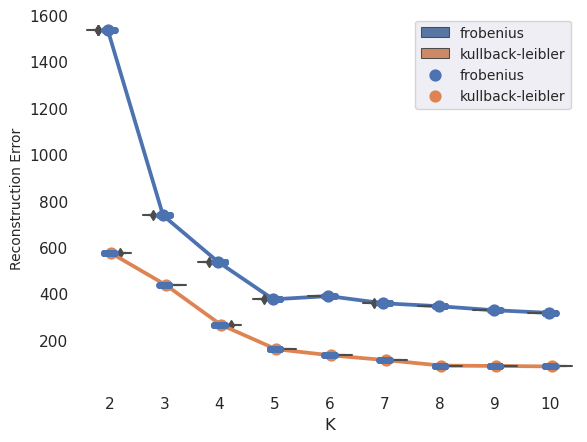

In [88]:
# Plot optimal k

res_f = res#[res['distance'] == 'frobenius']
ax = sb.boxplot(res_f, x='K', y = 'error', hue='distance', boxprops={'alpha': 0.1})
sb.stripplot(data=res_f, x="K", y="error", dodge=True, ax=ax)
sb.pointplot(data=res_f, x="K", y="error", hue="distance", dodge=True, ax=ax)
plt.legend( fontsize="10", loc ="upper right")
plt.ylabel("Reconstruction Error",fontsize="10")
ax.set_facecolor('white')
plt.savefig("nmf.pdf", facecolor=ax.get_facecolor(), transparent=True, dpi=500)
plt.show()



In [3]:
# fitting the model
model = NMF(n_components=5, init='nndsvda', solver='cd',
                                beta_loss='frobenius', max_iter=10000,random_state=7 )
W = model.fit_transform(data[curve_columns])
H = model.components_



/tmp/ipykernel_8641/1921734627.py:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  p = sb.lineplot(tmp, y='value', x='nm',


NameError: name 'ax' is not defined

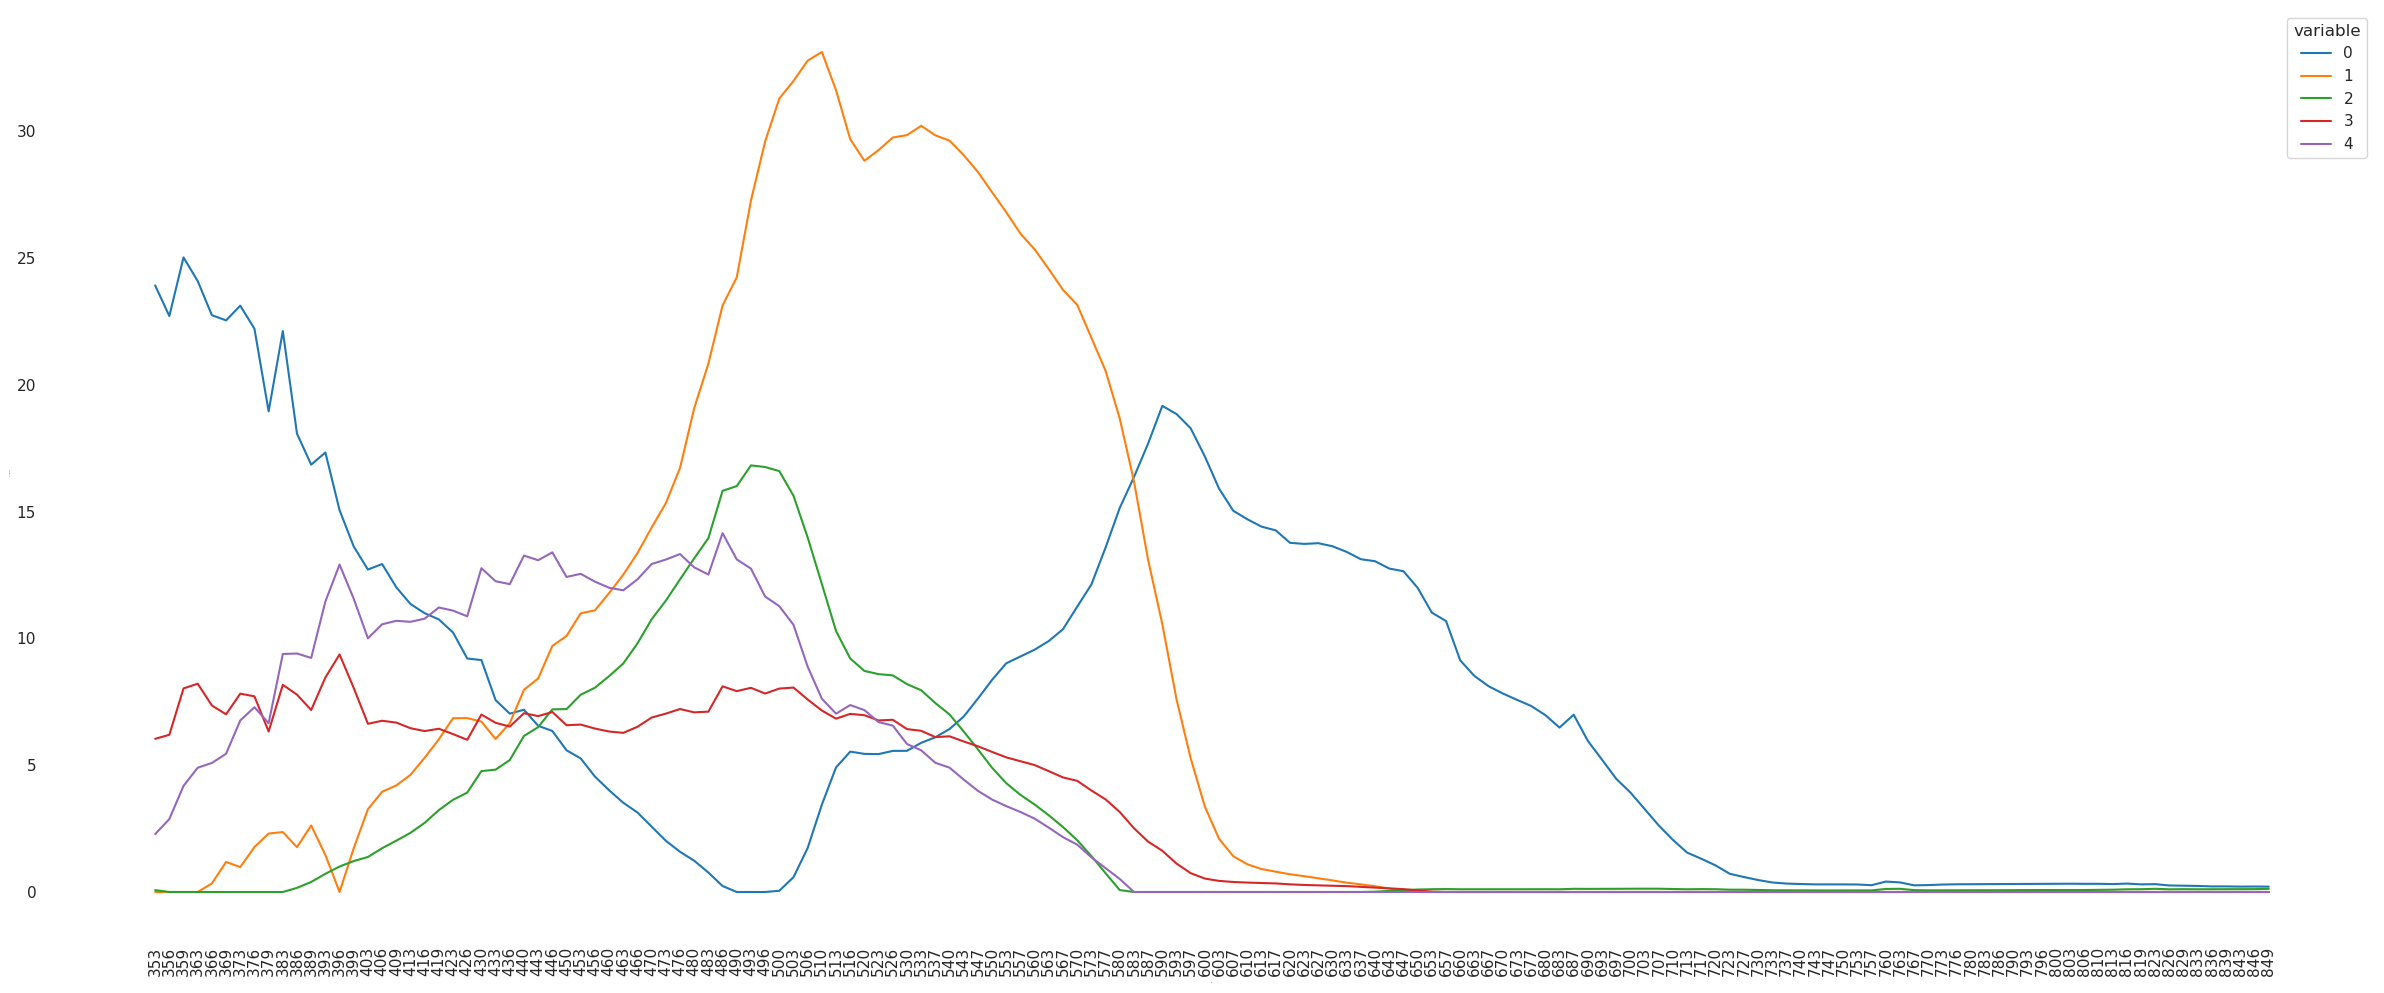

In [4]:
# Plotting the signatures
%matplotlib inline
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
tmp = pd.DataFrame(H).T
tmp['nm'] = curve_columns.values
tmp = tmp.melt(id_vars=['nm'])
plt.figure(figsize=(30,12))
p = sb.lineplot(tmp, y='value', x='nm',
               hue='variable',
               palette=sb.color_palette("tab10"))
sb.set(font_scale=1)
p.set_xlabel("nm",fontsize=1)
p.set_ylabel("% Apogee",fontsize=1)
plt.xticks(rotation=90)
plt.savefig("plots/signatures.pdf", facecolor=ax.get_facecolor(), transparent=True, dpi=100)
plt.show()


      Cast Sensor   Meter variable     value
0      6.0     UW  1.2925       S1  0.054389
1      6.0     UW  1.2925       S1  0.061607
2      6.0     UW  1.9137       S1  0.056053
3      6.0     UW  1.9137       S1  0.045266
4      6.0     UW  1.9875       S1  0.050500
...    ...    ...     ...      ...       ...
26980    8     DW  5.1652       S5  0.000000
26981    8     DW  5.1652       S5  0.000000
26982    8     DW  4.4936       S5  0.000000
26983    8     DW  4.2255       S5  0.047471
26984    8     DW  3.4930       S5  0.000000

[26985 rows x 5 columns]


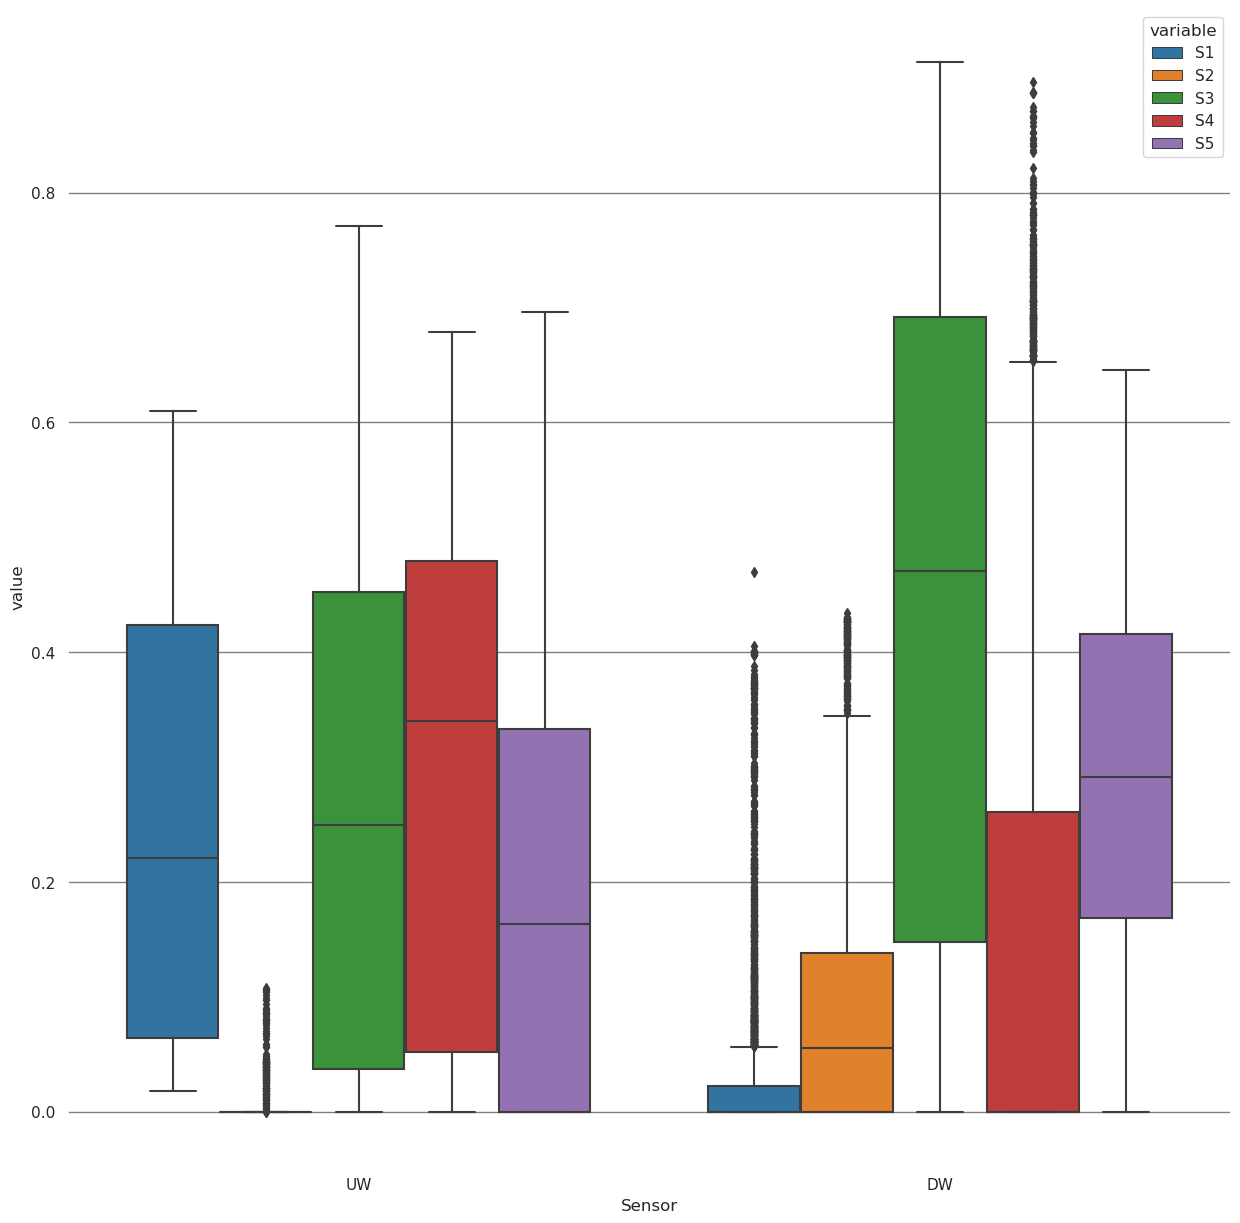

In [393]:
tmp = pd.DataFrame(W)
tmp.columns = ['S1', 'S2', 'S3', 'S4', 'S5']
tmp = ((tmp[['S1', 'S2', 'S3', 'S4', 'S5']].T/tmp.sum(axis=1).values).T)
tmp['Cast'] = data['Cast'].values
tmp['Sensor'] = data['Sensor'].values
tmp['Meter'] = data['Meter'].values


for_plot = tmp.melt(id_vars=['Cast', 'Sensor', 'Meter'])
print(for_plot)
plt.figure(figsize=(15,15))
p = sb.boxplot(for_plot, y='value', x='Sensor',hue='variable',
               palette=sb.color_palette("tab10"))
ax.set_facecolor('white')
plt.savefig("plots/sig_desc.pdf", facecolor=ax.get_facecolor(), transparent=True, dpi=900)
plt.show()



In [421]:
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white','grid.color': 'gray'})

for_plot_cast6 = tmp.groupby(['Cast','Sensor']).agg('median')
for_plot_cast6['Sensor'] = [i[1] for i in for_plot_cast6.index]


sb.lmplot(for_plot_cast6, x='S1', y = 'Meter',hue='Sensor', ci=None,palette="Set1", legend_out=False)
r = scipy.stats.pearsonr(x=for_plot_cast6['S1'], y=for_plot_cast6['Meter'])
plt.text(0.1,30, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.savefig('plots/signatures_depth_S1.pdf',dpi=20)
plt.close()

sb.lmplot(for_plot_cast6, x='S2', y = 'Meter', hue='Sensor' ,ci=None,palette="Set1", legend_out=False)
r = scipy.stats.pearsonr(x=for_plot_cast6['S2'], y=for_plot_cast6['Meter'])
plt.text(0.1, 30, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.savefig('plots/signatures_depth_S2.pdf',dpi=20)
plt.close()

sb.lmplot(for_plot_cast6, x='S3', y = 'Meter', hue='Sensor', ci=None,palette="Set1", legend_out=False)
r = scipy.stats.pearsonr(x=for_plot_cast6['S3'], y=for_plot_cast6['Meter'])
plt.text(0.1, 30, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.savefig('plots/signatures_depth_S3.pdf',dpi=20)
plt.close()

sb.lmplot(for_plot_cast6, x='S4', y = 'Meter', hue='Sensor', ci=None,palette="Set1", legend_out=False )
r = scipy.stats.pearsonr(x=for_plot_cast6['S4'], y=for_plot_cast6['Meter'])
plt.text(0.1, 30, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.savefig('plots/signatures_depth_S4.pdf',dpi=20)
plt.close()

sb.lmplot(for_plot_cast6, x='S5', y = 'Meter', hue='Sensor', ci=None,palette="Set1", legend_out=False)
r = scipy.stats.pearsonr(x=for_plot_cast6['S5'], y=for_plot_cast6['Meter'])
plt.text(0.1, 30, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.savefig('plots/signatures_depth_S5.pdf',dpi=20)
plt.close()


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code 

In [150]:
import glob
import tqdm

'''
Merge all spectra wiz files and make 1 file for each measure(depth)
'''
def make_merged_spectra_wiz(list_of_folders, location):
    for k in tqdm.tqdm(list_of_folders):
        spect_rows = []
        for f in glob.glob("KastelVisExp/{}/ApogeeData/{}/*.IRR".format(location,k)):
            apogee = pd.read_csv("{}".format(f), skiprows=1,sep=' ')
            apogee.columns = ['ignore1', 'nm', 'ignore2', 'value']
            apogee = apogee.drop(columns=['ignore1', 'ignore2'])
            apogee = apogee[apogee['nm'].between(350, 850)].T
            apogee = apogee[apogee.columns[::2]] # take every second column, so I have only round nms
            cols = apogee.head(1).values.tolist()[0]
            cols = [int(c) for c in cols]
            apogee = apogee.tail(1)
            time = f.split("#")[1].split(".")[0].replace("_", ":")
            apogee['TIMETAG2'] = time
            spect_rows.append(apogee)
            spect_data = pd.concat(spect_rows)
            cols.append("TIMETAG2")
            spect_data.columns = cols
            spect_data.to_csv("KastelVisExp/{}/ApogeeData/spectra_merged_{}.csv".format(location, k))

make_merged_spectra_wiz(['K0', 'K5', 'K10', 'K15', 'K20', 'K28'], 'Kastela')
make_merged_spectra_wiz(['V0', 'V5', 'V10', 'V20', 'V30', 'V50', 'V100'], 'Vis')


100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


In [9]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
location = 'Kastela'
'''
This can run for Vis or Kastel so change paramters accordingly.
it runs through folders, loads depth,appoge and experiment data.
In order to merge it some columns needs to be renamed and then checked for common column names
Lastly curve is normalized by appoge and inputed into NMF model from above
'''
vis_folders=[ 'V0','V5', 'V10', 'V20', 'V30', 'V50', 'V100']
kastel_folders = ['K0', 'K5', 'K10', 'K15', 'K20', 'K28']
signatures_in_exp = pd.DataFrame()
for folder in kastel_folders:
    for uw_dw in ['msm_dw', 'msm_uw']:
        if folder ==  '{}0'.format(location[0]):
            DEPTH = 1.8
        else:
            DEPTH = float(folder.split(location[0])[1])
        if folder == 'V100':
            DEPTH = 99
        if uw_dw == 'msm_dw':
            ED_column_start = 'ED(351.96)'
            ED_column_end = 'ED(850.90)'
        else:
            ED_column_start = 'EU(349.92)'
            ED_column_end = 'EU(852.88)'
        depth_file = glob.glob('KastelVisExp/{}/JohnnyFiveSonda/{}/*.asc'.format(location,folder))
        # depth data from experiment
        depth = pd.read_csv(depth_file[0],sep=',',skiprows=10)
        depth.columns = ['temp', 'depth','date', 'TIMETAG2']
        depth['TIMETAG2'] = depth['TIMETAG2'].str.strip()
        depth['TIMETAG2'] = pd.to_datetime(depth['TIMETAG2'])
        # Curve from experiment
        exp_data = pd.read_csv("KastelVisExp/{}/JohnnyFiveSonda/{}/{}.tsv".format(location,folder,uw_dw),sep='\t',skiprows=3)
        exp_data = exp_data.iloc[1::]
        start_index = exp_data.columns.get_loc(ED_column_start)
        end_index = exp_data.columns.get_loc(ED_column_end)
        exp_data.columns = exp_data.columns.str.replace('(', '')
        exp_data.columns = exp_data.columns.str.replace(')','')
        if uw_dw == 'msm_dw':
            exp_data.columns = exp_data.columns.str.replace('ED','')
        else:
            exp_data.columns = exp_data.columns.str.replace('EU','')
        tmp = exp_data.columns.str.split('.',1,expand=True)
        tmp_columns = []
        [tmp_columns.append(c[0]) for c in tmp]
        exp_data.columns = tmp_columns
        #print(exp_data)
        curve_columns = exp_data.columns[start_index:end_index].to_list()
        curve_columns.append('TIMETAG2')
        # take only curve 350-850 + timetag2
        exp_data = exp_data[curve_columns]
        # split time in order to ignore milis
        exp_data[['TIMETAG2', 'milis']] = exp_data['TIMETAG2'].str.split('.',1,expand=True)
        exp_data['TIMETAG2'] = exp_data['TIMETAG2'].str.strip()
        exp_data['TIMETAG2'] = pd.to_datetime(exp_data['TIMETAG2'])

        apogee = pd.read_csv('KastelVisExp/{}/ApogeeData/spectra_merged_{}.csv'.format(location,folder))
        apogee['TIMETAG2'] = pd.to_datetime(apogee['TIMETAG2'])
        common_columns = exp_data.columns.intersection(apogee.columns)
        if folder == 'V0':
            #apogee['TIMETAG2'] = apogee['TIMETAG2'] - pd.Timedelta(hours=0, minutes=23, seconds=0)
            #print(apogee)
            merged = pd.merge_asof(exp_data, apogee.sort_values('TIMETAG2'), on='TIMETAG2',
                                        tolerance=pd.Timedelta('15m'), suffixes=("_CTD", "_apogee"),
                                       direction='nearest', allow_exact_matches=True)
        else:
            merged = pd.merge_asof(exp_data, apogee.sort_values('TIMETAG2'), on='TIMETAG2',
                                        tolerance=pd.Timedelta('2s'), suffixes=("_CTD", "_apogee"),
                                       direction='nearest', allow_exact_matches=True)
        merged = pd.merge_asof(merged, depth.sort_values('TIMETAG2'), on='TIMETAG2',
                                tolerance=pd.Timedelta('2s'),
                               direction='nearest', allow_exact_matches=True)
        merged = merged[merged['depth'].between(DEPTH-0.5, DEPTH+0.5)]
        ctd_columns = merged.columns[merged.columns.str.endswith('CTD')]
        apogee_columns = merged.columns[merged.columns.str.endswith('apogee')]
        merged[ctd_columns] = merged[ctd_columns].apply(pd.to_numeric)
        merged[apogee_columns] = merged[apogee_columns].apply(pd.to_numeric)
        normalized_curve = pd.DataFrame((merged[ctd_columns].values/(merged[apogee_columns].values+1)) *100)
        normalized_curve[normalized_curve < 0] = 0
        normalized_curve.mean(axis=0).to_csv('{}_{}_{}.csv'.format(location,folder,uw_dw))
        res = model.transform(normalized_curve)
        res = res.mean(axis=0)
        res = res/res.sum()
        row = {'sample': folder,'depth':DEPTH, 'UW_DW': uw_dw, 'S1': res[0], 'S2':res[1], 'S3':res[2], 'S4': res[3], 'S5':res[4]}
        print(row)
        signatures_in_exp = pd.concat([signatures_in_exp, pd.DataFrame([row])], axis=0,ignore_index=True)

signatures_in_exp

/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K0', 'depth': 1.8, 'UW_DW': 'msm_dw', 'S1': 0.42915387318073933, 'S2': 0.12467112858568095, 'S3': 0.358518669419981, 'S4': 0.0, 'S5': 0.08765632881359865}
{'sample': 'K0', 'depth': 1.8, 'UW_DW': 'msm_uw', 'S1': 0.49913346226924515, 'S2': 0.0, 'S3': 0.500866537730755, 'S4': 0.0, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K5', 'depth': 5.0, 'UW_DW': 'msm_dw', 'S1': 0.4508810685275794, 'S2': 0.07419235395612957, 'S3': 0.4115368013286444, 'S4': 0.0029942870078874637, 'S5': 0.06039548917975924}
{'sample': 'K5', 'depth': 5.0, 'UW_DW': 'msm_uw', 'S1': 0.11229644781630942, 'S2': 0.03835025316364061, 'S3': 0.405979089853172, 'S4': 0.3903759385095394, 'S5': 0.05299827065733862}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K10', 'depth': 10.0, 'UW_DW': 'msm_dw', 'S1': 0.15349011289872438, 'S2': 0.34229391770850515, 'S3': 0.08476455876881667, 'S4': 6.009506350889407e-05, 'S5': 0.41939131556044484}
{'sample': 'K10', 'depth': 10.0, 'UW_DW': 'msm_uw', 'S1': 0.08011968683630813, 'S2': 0.012083878903583384, 'S3': 0.5728244967584061, 'S4': 0.3018604760383521, 'S5': 0.03311146146335041}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K15', 'depth': 15.0, 'UW_DW': 'msm_dw', 'S1': 0.021277875040328284, 'S2': 0.2757253248850267, 'S3': 0.2728486400100552, 'S4': 0.09047048967318551, 'S5': 0.33967767039140434}
{'sample': 'K15', 'depth': 15.0, 'UW_DW': 'msm_uw', 'S1': 0.0902634825748433, 'S2': 0.0009725195470088215, 'S3': 0.6687525919510111, 'S4': 0.2400114059271366, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K20', 'depth': 20.0, 'UW_DW': 'msm_dw', 'S1': 0.03503621983876426, 'S2': 0.17174705557975425, 'S3': 0.5905252491396668, 'S4': 0.07483650489901746, 'S5': 0.12785497054279732}
{'sample': 'K20', 'depth': 20.0, 'UW_DW': 'msm_uw', 'S1': 0.3672690797540627, 'S2': 0.0, 'S3': 0.5934446917548047, 'S4': 0.03928622849113253, 'S5': 0.0}
{'sample': 'K28', 'depth': 28.0, 'UW_DW': 'msm_dw', 'S1': 0.1174511204726069, 'S2': 0.08933479729581098, 'S3': 0.7932140822315821, 'S4': 0.0, 'S5': 0.0}
{'sample': 'K28', 'depth': 28.0, 'UW_DW': 'msm_uw', 'S1': 0.4677524431576035, 'S2': 0.0, 'S3': 0.5322475568423964, 'S4': 0.0, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


,sample,depth,UW_DW,S1,S2,S3,S4,S5
0,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
2,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
3,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
4,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
5,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111
6,K15,15.0,msm_dw,0.021278,0.275725,0.272849,0.090470,0.339678
7,K15,15.0,msm_uw,0.090263,0.000973,0.668753,0.240011,0.000000
8,K20,20.0,msm_dw,0.035036,0.171747,0.590525,0.074837,0.127855
9,K20,20.0,msm_uw,0.367269,0.000000,0.593445,0.039286,0.000000


In [6]:
all_curves = pd.DataFrame()
curve_columns = curve_columns[1:-1]
print(curve_columns[2:-2])
for f in glob.glob("KastelVisExp/experimentCurves/*.csv"):
    print(f)
    parts = f.split('_')
    curve = pd.read_csv(f)
    curve.columns = ['nm', 'value']
    curve['nm'] = curve_columns
    curve['nm']= curve['nm'].astype('float')
    curve['location'] = parts[0]
    curve['sample'] = parts[1]
    curve['UW_DW'] = parts[3].split('.')[0]
    all_curves = pd.concat([all_curves, curve])

print(all_curves)
vis_curves = all_curves
sb.pointplot(all_curves, x = 'nm', y = 'value', hue='sample')

['359', '363', '366', '369', '373', '376', '379', '383', '386', '389', '393', '396', '399', '403', '406', '409', '413', '416', '419', '423', '426', '430', '433', '436', '440', '443', '446', '450', '453', '456', '460', '463', '466', '470', '473', '476', '480', '483', '486', '490', '493', '496', '500', '503', '506', '510', '513', '516', '520', '523', '526', '530', '533', '537', '540', '543', '547', '550', '553', '557', '560', '563', '567', '570', '573', '577', '580', '583', '587', '590', '593', '597', '600', '603', '607', '610', '613', '617', '620', '623', '627', '630', '633', '637', '640', '643', '647', '650', '653', '657', '660', '663', '667', '670', '673', '677', '680', '683', '687', '690', '693', '697', '700', '703', '707', '710', '713', '717', '720', '723', '727', '730', '733', '737', '740', '743', '747', '750', '753', '757', '760', '763', '767', '770', '773', '776', '780', '783', '786', '790', '793', '796', '800', '803', '806', '810', '813', '816', '819', '823', '826', '829', '833'

ValueError: Length of values (150) does not match length of index (148)

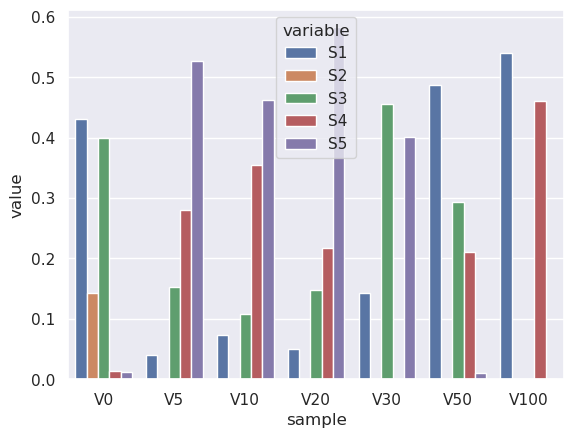

In [7]:
for_plot = signatures_in_exp.melt(id_vars=['sample','depth','UW_DW'])
for_plotDW = for_plot[for_plot['UW_DW'] == 'msm_dw'].copy()
sb.barplot(for_plotDW, x='sample', y ='value', hue='variable')
plt.savefig('signatures_in_{}_dw.pdf'.format(location),dpi=20)
plt.close()
for_plotUW = for_plot[for_plot['UW_DW'] == 'msm_uw'].copy()
sb.barplot(for_plotUW, x='sample', y ='value', hue='variable')
plt.savefig('signatures_in_{}_uw.pdf'.format(location),dpi=20)

In [11]:
signatures_in_exp_Kastela = signatures_in_exp

In [12]:
signatures_in_both = pd.concat([signatures_in_exp_Vis,signatures_in_exp_Kastela])
signatures_in_both

,sample,depth,UW_DW,S1,S2,S3,S4,S5
0,V0,1.8,msm_dw,0.421611,0.121317,0.341025,0.027584,0.088462
1,V0,1.8,msm_uw,0.430734,0.143169,0.399917,0.014184,0.011996
2,V5,5.0,msm_dw,0.254787,0.106228,0.222920,0.314442,0.101623
3,V5,5.0,msm_uw,0.040229,0.000000,0.152842,0.279948,0.526981
4,V10,10.0,msm_dw,0.144992,0.113122,0.177536,0.361932,0.202419
5,V10,10.0,msm_uw,0.073765,0.000000,0.108759,0.355546,0.461931
6,V20,20.0,msm_dw,0.017038,0.065719,0.183818,0.468681,0.264743
7,V20,20.0,msm_uw,0.050898,0.000000,0.148149,0.218070,0.582883
8,V30,30.0,msm_dw,0.000292,0.056878,0.415715,0.163462,0.363653
9,V30,30.0,msm_uw,0.143436,0.000000,0.455977,0.000000,0.400587


In [19]:
cyano_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
cyano_data = cyano_data.merge(signatures_in_both, left_on='Station', right_on='sample')
cyano_data

,Station,Location,WhoDidIt,depth_x,PP_LSR,EOC_LSR,EOC/POC_LSR,PPSplit,EOC/PP_LSR,Chla,...,bacteria,%HNA bacteria,sample,depth_y,UW_DW,S1,S2,S3,S4,S5
0,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
2,K0,Kastela,Split,0,0.19,2.04,10.65,0.080,1064.644970,NaN,...,NaN,NaN,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
3,K0,Kastela,Split,0,0.19,2.04,10.65,0.080,1064.644970,NaN,...,NaN,NaN,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
4,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
5,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
6,K5,Kastela,Split,5,0.37,2.51,6.70,0.060,669.681083,NaN,...,NaN,NaN,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
7,K5,Kastela,Split,5,0.37,2.51,6.70,0.060,669.681083,NaN,...,NaN,NaN,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
8,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
9,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111


In [30]:
tmp= cyano_data[['S1','S2','S3','S4','S5','UW_DW','Location', 'Synechococcus','bacteria','heterotrofic nanoflagellates', 'picoeukaryotes', 'Prochlorococcus','Chla']]
print(cyano_data)
tmp_uw = tmp.query("Location == 'Kastela' and UW_DW == 'msm_dw'")
plt.figure(figsize=(16, 16))
mask = np.triu(np.ones_like(tmp_uw.corr()))
sb.heatmap(tmp_uw.corr(),annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True),mask=mask )
plt.savefig('plots/cyano_by_signatures_Kastela_dw.pdf',dpi=20)
plt.close()
tmp_uw = tmp.query("Location == 'Vis' and UW_DW == 'msm_dw'")
plt.figure(figsize=(16, 16))
mask = np.triu(np.ones_like(tmp_uw.corr()))
sb.heatmap(tmp_uw.corr(),annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True),mask=mask )
plt.savefig('plots/cyano_by_signatures_Vis_dw.pdf',dpi=20)
plt.close()

   Station Location WhoDidIt  depth_x  PP_LSR  EOC_LSR  EOC/POC_LSR  PPSplit  \
0       K0  Kastela  Marinix        0    4.25     2.52         0.59    3.260   
1       K0  Kastela  Marinix        0    4.25     2.52         0.59    3.260   
2       K0  Kastela    Split        0    0.19     2.04        10.65    0.080   
3       K0  Kastela    Split        0    0.19     2.04        10.65    0.080   
4       K5  Kastela  Marinix        5    4.06     2.88         0.71    1.050   
5       K5  Kastela  Marinix        5    4.06     2.88         0.71    1.050   
6       K5  Kastela    Split        5    0.37     2.51         6.70    0.060   
7       K5  Kastela    Split        5    0.37     2.51         6.70    0.060   
8      K10  Kastela  Marinix       10    0.91     2.73         3.01    0.890   
9      K10  Kastela  Marinix       10    0.91     2.73         3.01    0.890   
10     K10  Kastela    Split       10    0.33     2.28         7.00    0.040   
11     K10  Kastela    Split       10   

In [97]:
tmp = cyano_data[['Synechococcus','bacteria','heterotrofic nanoflagellates', 'picoeukaryotes','Prochlorococcus','depth_x', 'Station']]
tmp_uw = tmp#[tmp['Station'].str.startsWI == 'msm_uw']
tmp_uw = tmp_uw.melt(id_vars=['Station', 'depth_x'])
print(tmp_uw)
sb.lmplot(tmp_uw, x='depth_x', y='value', hue='variable',ci=None,order=2)
plt.savefig('plots/correlation_depth_cyanos_UW.pdf', dpi=20)
plt.close()
tmp_dw = tmp#[tmp['Station'] == 'msm_dw']
tmp_dw = tmp_dw.melt(id_vars=['Station', 'depth_x'])
sb.lmplot(tmp_dw, x='depth_x', y='value', hue='variable',ci=None,order=2)
plt.savefig('plots/correlation_depth_cyanos_DW.pdf', dpi=20)
plt.close()

    Station  depth_x         variable  value
0        V0        0    Synechococcus  10.28
1        V0        0    Synechococcus  10.28
2        V0        0    Synechococcus  10.28
3        V0        0    Synechococcus  10.28
4        V5        5    Synechococcus   9.47
..      ...      ...              ...    ...
135     V50       50  Prochlorococcus  14.27
136    V100      100  Prochlorococcus  33.00
137    V100      100  Prochlorococcus  33.00
138    V100      100  Prochlorococcus  33.00
139    V100      100  Prochlorococcus  33.00

[140 rows x 4 columns]


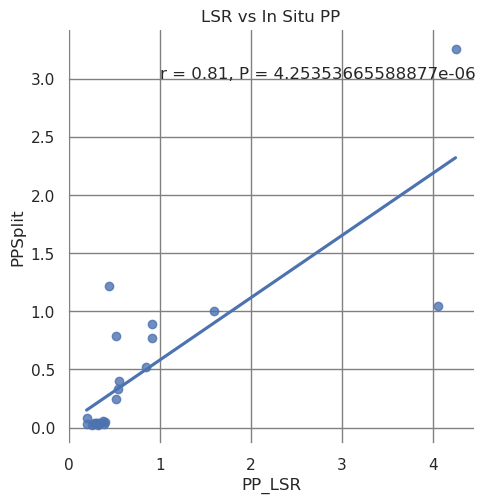

In [284]:
'''
Are we measuring the same primary productivty as split? Yes
But they are often measuring smaller.
'''
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'gray'})
import scipy
for_cor = cyano_data[['PP_LSR', 'PPSplit']].dropna()
r = scipy.stats.pearsonr(x=for_cor['PP_LSR'], y=for_cor['PPSplit'])
tmp = cyano_data
g = sb.lmplot(x='PP_LSR', y='PPSplit', data=cyano_data,ci=False)
plt.text(1, 3, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.title('LSR vs In Situ PP')
plt.savefig('plots/insitu_vs_lsr_pp.pdf',dpi=10)

In [287]:
productivty = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet2.csv")
#productivty = productivty.merge(signatures_in_both, left_on='Station', right_on='sample')
productivty

,LSR Socket,Station,Location,uW/cm2,POC(dpm),EOC(dpm),POC(PPP),EOC(DPP),EOC/POC
0,1,K0,Kastela,23500.0,9720.0,5780.0,4.250,2.52,0.594
1,2,K0,Kastela,22000.0,8850.0,4890.0,3.870,2.14,0.553
2,3,K0,Kastela,22900.0,8460.0,5010.0,3.700,2.19,0.592
3,4,K0,Kastela,13300.0,9560.0,5210.0,4.180,2.28,0.545
4,5,K0,Kastela,11900.0,10100.0,4960.0,4.410,2.17,0.491
...,...,...,...,...,...,...,...,...,...
163,8,V100,Vis,82.0,1040.0,12600.0,0.414,5.02,12.100
164,9,V100,Vis,56.0,767.0,11700.0,0.306,4.68,15.300
165,10,V100,Vis,52.0,646.0,12000.0,0.258,4.78,18.600
166,11,V100,Vis,0.0,1310.0,10900.0,0.523,4.36,8.340


    Station  LSR Socket Location   uW/cm2  variable     value
0        K0           1  Kastela  23500.0  POC(dpm)   9720.00
1        K0           2  Kastela  22000.0  POC(dpm)   8850.00
2        K0           3  Kastela  22900.0  POC(dpm)   8460.00
3        K0           4  Kastela  13300.0  POC(dpm)   9560.00
4        K0           5  Kastela  11900.0  POC(dpm)  10100.00
..      ...         ...      ...      ...       ...       ...
835    V100           8      Vis     82.0   EOC/POC     12.10
836    V100           9      Vis     56.0   EOC/POC     15.30
837    V100          10      Vis     52.0   EOC/POC     18.60
838    V100          11      Vis      0.0   EOC/POC      8.34
839    V100          12      Vis      0.0   EOC/POC     13.60

[840 rows x 6 columns]


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


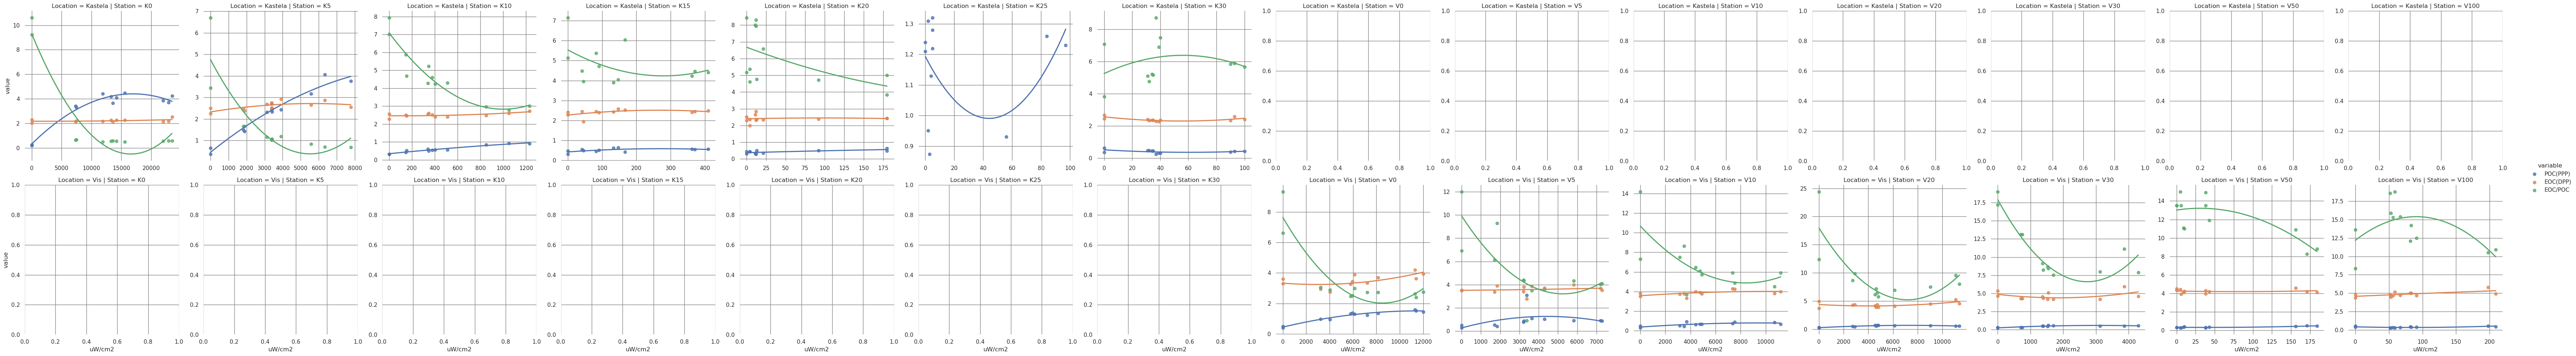

In [288]:
tmp = productivty.melt(id_vars=['Station','LSR Socket','Location', 'uW/cm2'])
print(tmp)
tmp = tmp[tmp['variable'].isin(['POC(PPP)', 'EOC(DPP)', 'EOC/POC'])]
tmp['LSR Socket'] = tmp['LSR Socket'].astype('category')
sb.lmplot(
    data=tmp,
    x="uW/cm2", y="value", row='Location',col='Station', ci = False, hue='variable',order=2,
    sharex=False,sharey=False
)
plt.savefig('plots/all_productivity.pdf', dpi=100)

In [193]:
cyano_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
productivty = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet2.csv")
productivty = productivty.merge(cyano_data, on='Station')
productivty

,LSR Socket,Station,Location_x,uW/cm2,POC(dpm),EOC(dpm),POC(PPP),EOC(DPP),EOC/POC,Location_y,...,EOC/POC_LSR,PPSplit,EOC/PP_LSR,Chla,Synechococcus,Prochlorococcus,picoeukaryotes,heterotrofic nanoflagellates,bacteria,%HNA bacteria
0,1,K0,Kastela,23500.0,9720.0,5780.0,4.250,2.52,0.594,Kastela,...,0.59,3.26,59.416995,0.44,30.5,1.39,3.37,0.38,0.31359,37.906183
1,1,K0,Kastela,23500.0,9720.0,5780.0,4.250,2.52,0.594,Kastela,...,10.65,0.08,1064.644970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,K0,Kastela,22000.0,8850.0,4890.0,3.870,2.14,0.553,Kastela,...,0.59,3.26,59.416995,0.44,30.5,1.39,3.37,0.38,0.31359,37.906183
3,2,K0,Kastela,22000.0,8850.0,4890.0,3.870,2.14,0.553,Kastela,...,10.65,0.08,1064.644970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,K0,Kastela,22900.0,8460.0,5010.0,3.700,2.19,0.592,Kastela,...,0.59,3.26,59.416995,0.44,30.5,1.39,3.37,0.38,0.31359,37.906183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,10,V100,Vis,52.0,646.0,12000.0,0.258,4.78,18.600,Vis,...,13.57,NaN,1356.929249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,11,V100,Vis,0.0,1310.0,10900.0,0.523,4.36,8.340,Vis,...,10.53,NaN,1052.735022,0.34,2.0,33.00,0.83,0.10,0.15397,44.904852
309,11,V100,Vis,0.0,1310.0,10900.0,0.523,4.36,8.340,Vis,...,13.57,NaN,1356.929249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,12,V100,Vis,0.0,891.0,12100.0,0.356,4.83,13.600,Vis,...,10.53,NaN,1052.735022,0.34,2.0,33.00,0.83,0.10,0.15397,44.904852


In [374]:
cyano_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
cyano_data = cyano_data.merge(signatures_in_both, left_on='Station', right_on='sample')
cyano_data = cyano_data[cyano_data['WhoDidIt'] == 'Marinix']
cyano_data

,Station,Location,WhoDidIt,depth_x,PP_LSR,EOC_LSR,EOC/POC_LSR,PPSplit,EOC/PP_LSR,Chla,...,bacteria,%HNA bacteria,sample,depth_y,UW_DW,S1,S2,S3,S4,S5
0,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
4,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
5,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
8,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
9,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111
12,K15,Kastela,Marinix,15,0.57,2.41,4.23,NaN,423.273657,0.33,...,0.51039,46.150983,K15,15.0,msm_dw,0.021278,0.275725,0.272849,0.090470,0.339678
13,K15,Kastela,Marinix,15,0.57,2.41,4.23,NaN,423.273657,0.33,...,0.51039,46.150983,K15,15.0,msm_uw,0.090263,0.000973,0.668753,0.240011,0.000000
16,K20,Kastela,Marinix,20,0.51,2.39,4.73,0.790,472.755418,0.27,...,0.48276,45.169442,K20,20.0,msm_dw,0.035036,0.171747,0.590525,0.074837,0.127855
17,K20,Kastela,Marinix,20,0.51,2.39,4.73,0.790,472.755418,0.27,...,0.48276,45.169442,K20,20.0,msm_uw,0.367269,0.000000,0.593445,0.039286,0.000000


In [391]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression



for dw_uw in ['msm_dw', 'msm_uw']:
    for y in ['Prochlorococcus', 'Synechococcus', 'picoeukaryotes', 'heterotrofic nanoflagellates', 'bacteria', '%HNA bacteria']:
        tmp = cyano_data[cyano_data['UW_DW'] == dw_uw].copy()
        X = tmp[['S1', 'S2', 'S3','S4', 'S5', 'depth_x']].values
        Y = tmp[y].values
        reg = LinearRegression(copy_X=True).fit(X, Y)
        print("RMSE:",np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))))
        tmp['predicted_{}'.format(y)] = reg.predict(X)
        sb.lmplot(tmp, x=y, y='predicted_{}'.format(y), ci=False)
        if y == 'heterotrofic nanoflagellates':
            plt.text(min(Y),min(reg.predict(X)), dw_uw)
            plt.text(min(Y),min(reg.predict(X))+0.1, [round(i,2) for i in reg.coef_])
            plt.text(min(Y),min(reg.predict(X))+0.2, "RMSE = {}".format(round(np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))), 2)))
        else:
            plt.text(min(Y),min(reg.predict(X)), dw_uw)
            plt.text(min(Y),min(reg.predict(X))+1, [round(i,2) for i in reg.coef_])
            plt.text(min(Y),min(reg.predict(X))+2, "RMSE = {}".format(round(np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))), 2)))
        plt.savefig('plots/predicted_{}_{}.pdf'.format(y,dw_uw), dpi=50)
        plt.close()

RMSE: 1.266627633907176
RMSE: 4.540673090593326
RMSE: 0.3915296923509522
RMSE: 0.03764698409713251
RMSE: 0.08193657495987741
RMSE: 4.743717218458206
RMSE: 0.8904746485941701
RMSE: 2.498452386481796
RMSE: 0.4017962733480605
RMSE: 0.06449821614468437
RMSE: 0.06244589265535794
RMSE: 3.1681469831179503


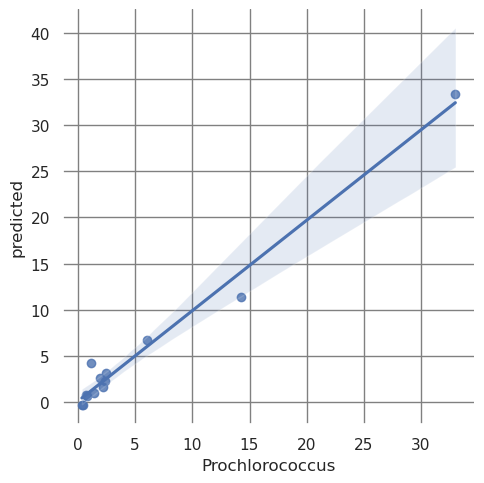